In [1]:
import numpy as np
import pandas as pd
import random
import os
import zipfile
from PIL import Image
import seaborn as sns
import shutil
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization,Input,GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix , classification_report, ConfusionMatrixDisplay
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau)
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split



In [2]:
!git clone https://github.com/DiegoAT26/IABO_cats_dogs.git

Cloning into 'IABO_cats_dogs'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), 8.45 KiB | 8.45 MiB/s, done.


# Unzip and Load The Data

se descargan los archivos test1.zip y train.zip de kaggle de https://www.kaggle.com/c/dogs-vs-cats/overview  para realizar el proceso y se suben a colab. No fue posible cargarlos a git por el tamaño y se presenta un error al intentar enlazarlo directamente de Kaggle.

1.   Elemento de la lista
2.   Elemento de la lista



In [6]:
import zipfile
import os

train_path = '/content/train.zip'
test_path = '/content/test1.zip'

def descomprimir_archivo(zip_path, extract_to):
    # Verifica si el archivo existe
    if not os.path.exists(zip_path):
        print(f"El archivo {zip_path} no existe.")
        return

    # Verifica si el archivo es un archivo ZIP válido
    if zipfile.is_zipfile(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
            print(f"Archivos extraídos de {zip_path} en: {extract_to}")
    else:
        print(f"{zip_path} no es un archivo ZIP válido.")

# Directorio donde se descomprimirá el contenido
directorio_destino_train = '/content/train_files'
directorio_destino_test = '/content/test_files'

# Descomprimir los archivos ZIP
descomprimir_archivo(train_path, directorio_destino_train)
descomprimir_archivo(test_path, directorio_destino_test)



Archivos extraídos de /content/train.zip en: /content/train_files
Archivos extraídos de /content/test1.zip en: /content/test_files


In [7]:
train_data_path='/content/train_files/train'
test_data_path='/content/test_files/test1'

train_images=os.listdir(train_data_path)
test_images=os.listdir(test_data_path)

# Get the images into DataFrame

In [8]:
image_name=[]
category=[]
code=[]
size=[]
aspect_ratio=[]

for image in train_images:
    image_name.append(image)
    cate=image.split('.')[0]
    category.append(cate)
    code.append(1) if cate=='dog'  else code.append(0)

    img_path=os.path.join(train_data_path,image)
    # Read the image to get its size (height, width)
    img=cv2.imread(img_path)
    size.append((img.shape[0],img.shape[1]))
    # Calculate and append the aspect ratio (height/width) of the image
    aspect_ratio.append(img.shape[0]/img.shape[1])

train_df=pd.DataFrame({'Image_Name':image_name,'Category':category,'Code':code,"Size":size,'Aspect_ratio':aspect_ratio})
train_df

Image_Name Category  Code        Size  Aspect_ratio
0      dog.12192.jpg      dog     1  (239, 320)      0.746875
1      cat.10840.jpg      cat     0  (499, 355)      1.405634
2       dog.8033.jpg      dog     1  (374, 500)      0.748000
3       dog.5652.jpg      dog     1  (377, 500)      0.754000
4      dog.10866.jpg      dog     1  (398, 400)      0.995000
...              ...      ...   ...         ...           ...
24995   dog.9050.jpg      dog     1  (466, 499)      0.933868
24996   cat.6571.jpg      cat     0  (334, 499)      0.669339
24997  dog.11053.jpg      dog     1  (400, 265)      1.509434
24998   dog.4035.jpg      dog     1  (300, 399)      0.751880
24999   dog.8548.jpg      dog     1  (481, 500)      0.962000

[25000 rows x 5 columns]

In [9]:
# Define a function to display the first 9 images from a DataFrame
def display_first_9(path,df):
    plt.figure(figsize=[30,30])
    for i in range(9):
        plt.subplot(3,3,i+1)
        img_path=os.path.join(path,df['Image_Name'].iloc[i])
        plt.title(df['Image_Name'][i])
        img=Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

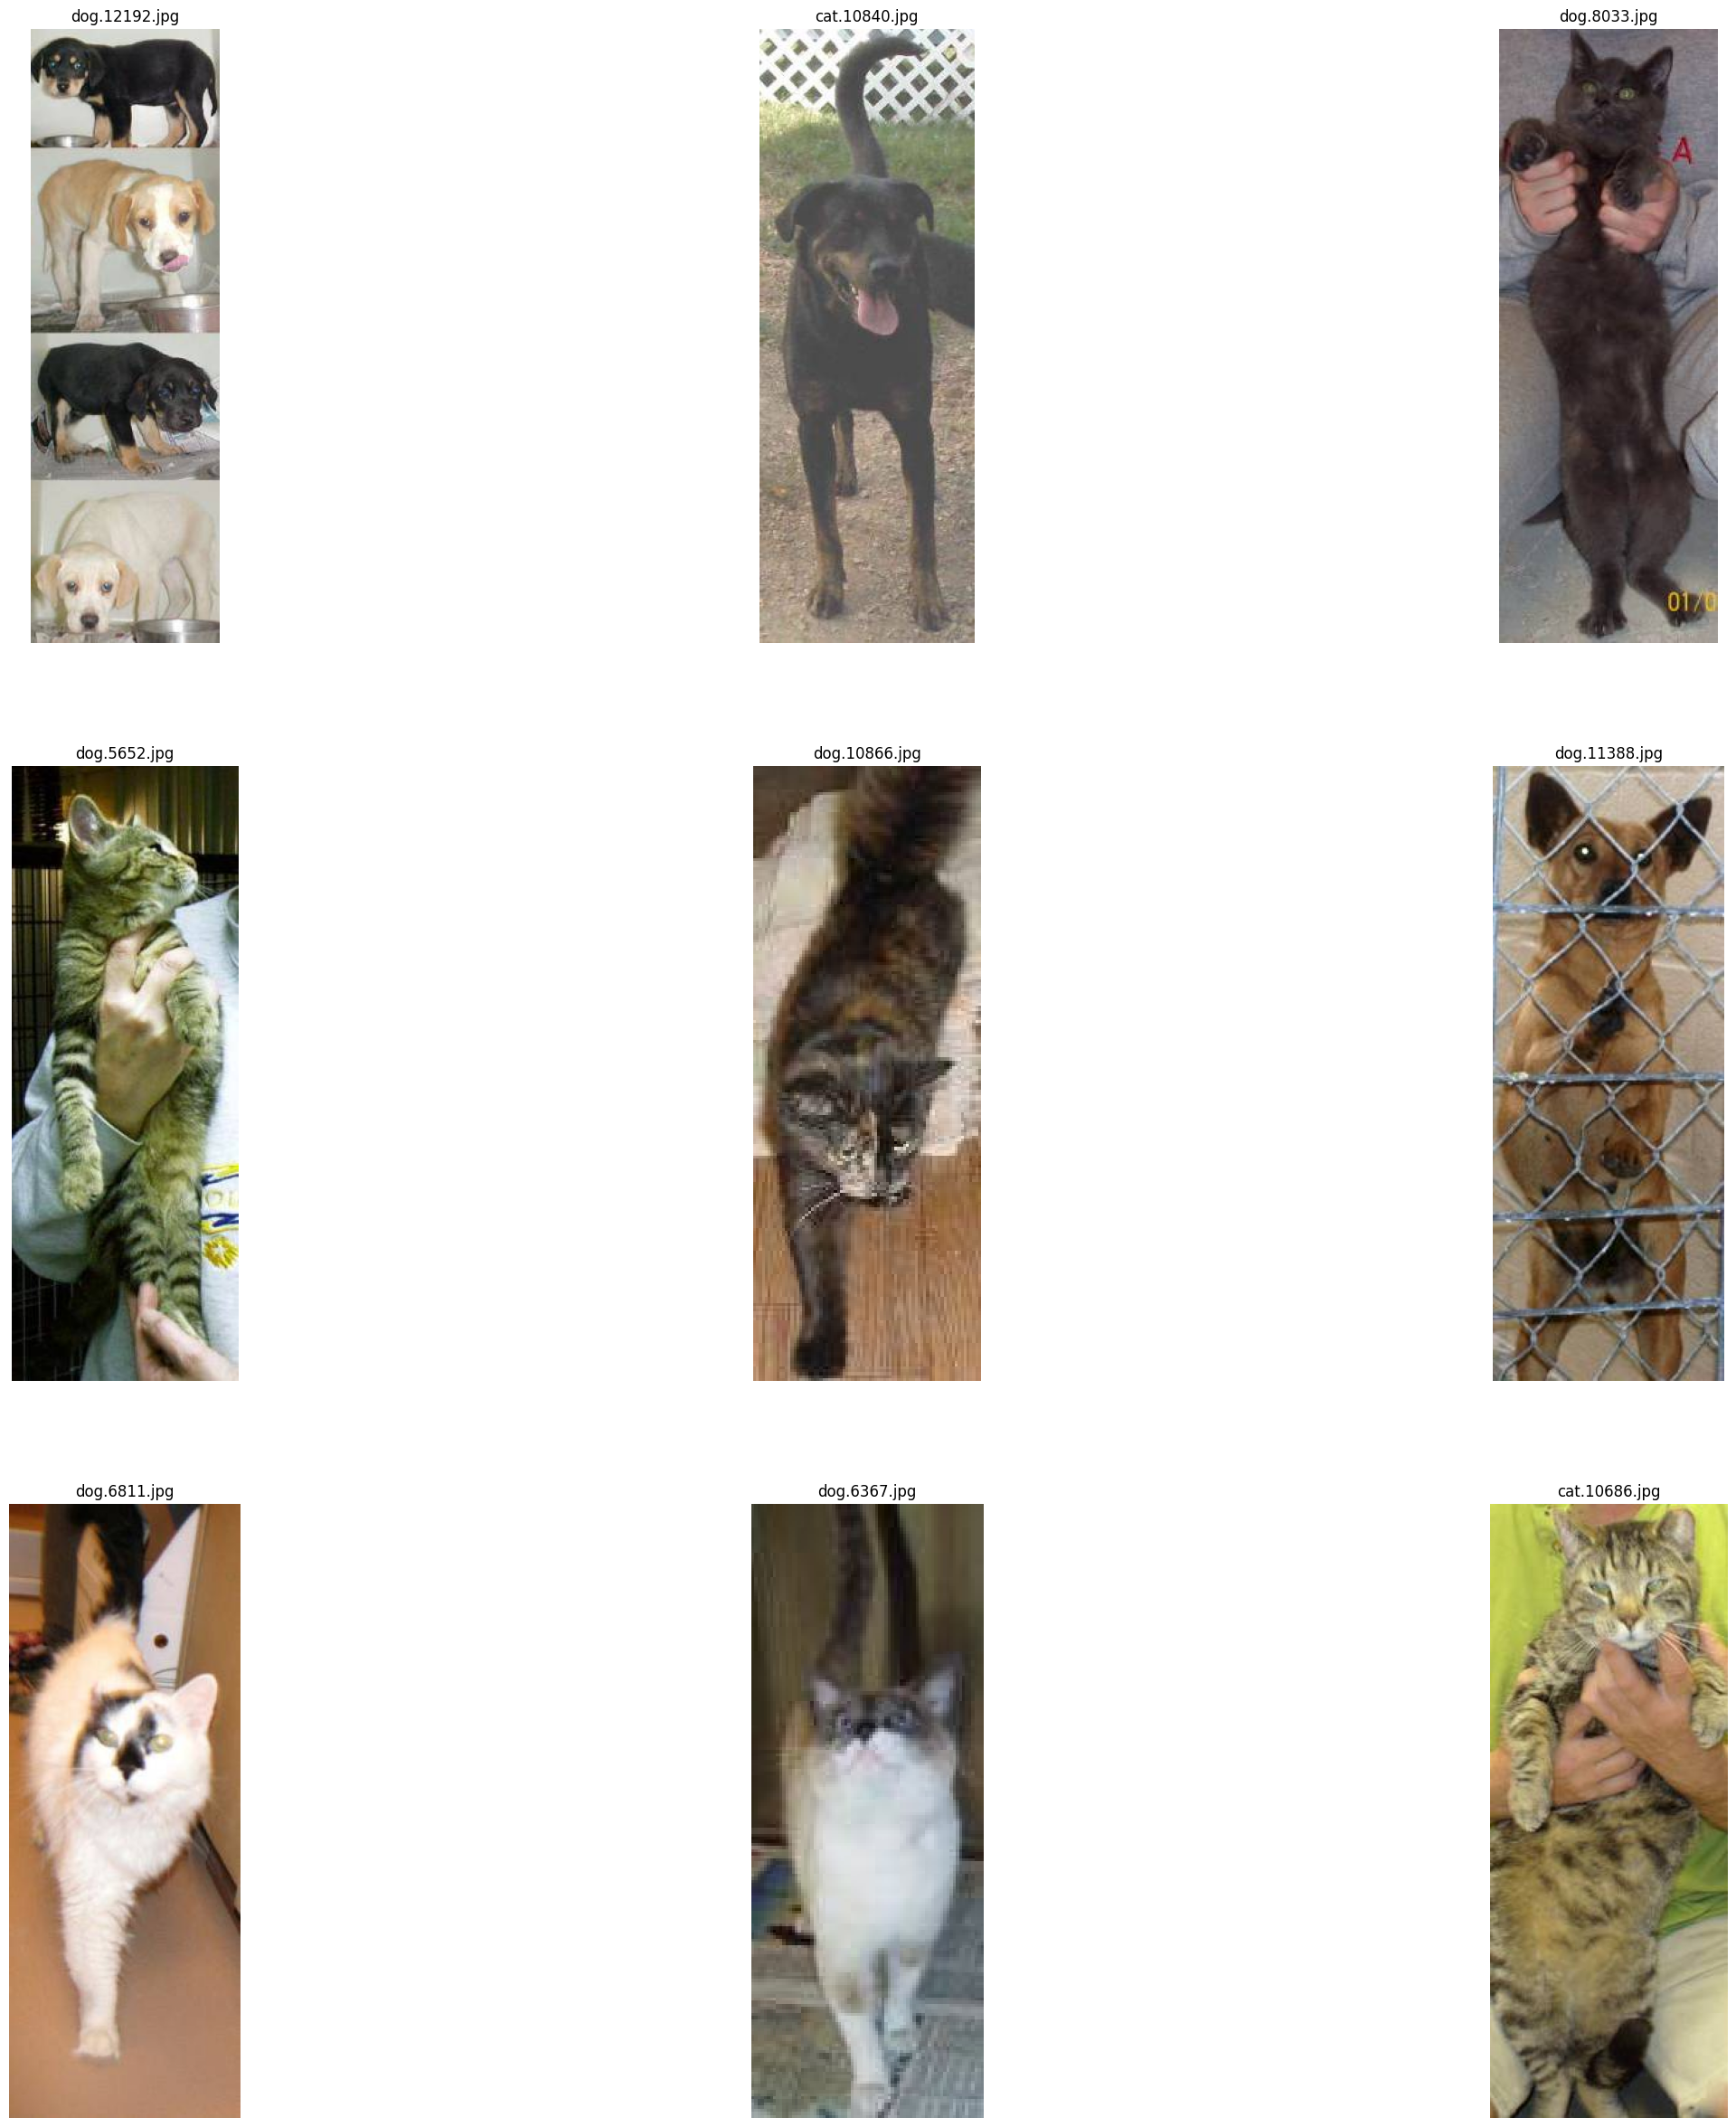

In [10]:
df_sorted=train_df.sort_values(by='Aspect_ratio',ascending=False)
display_first_9(train_data_path,df_sorted)

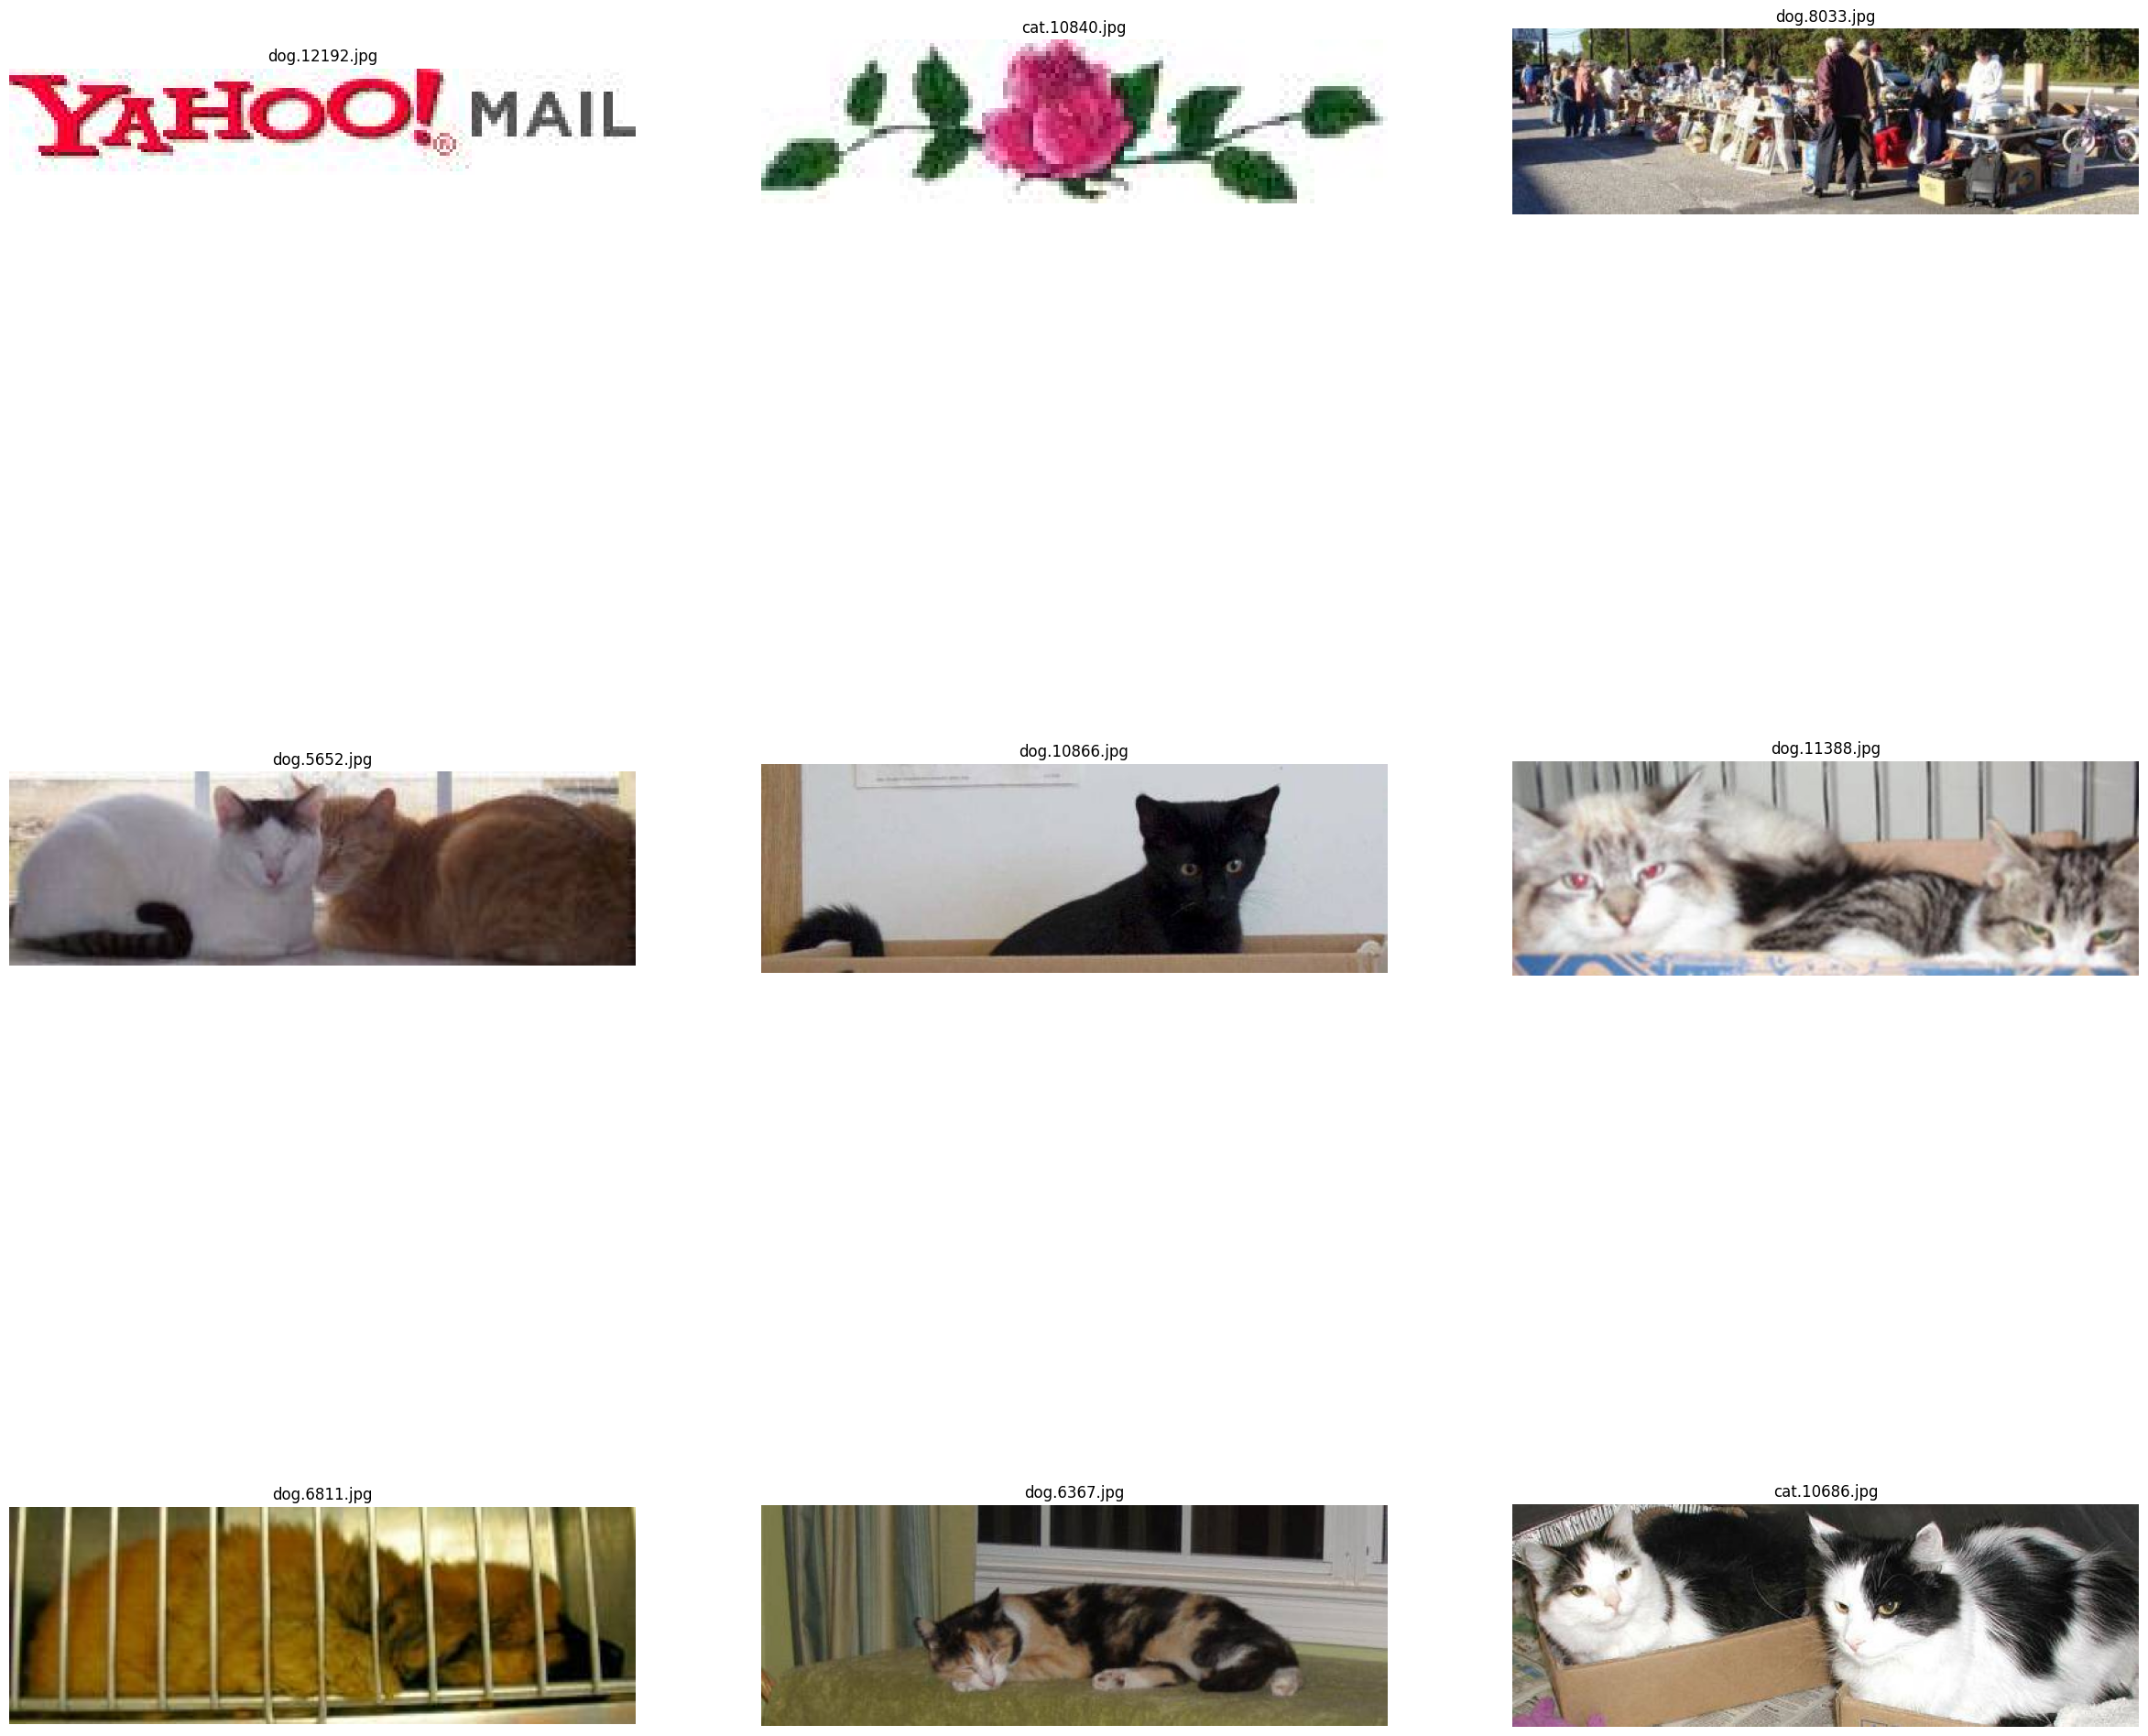

In [11]:
df_sorted=train_df.sort_values(by='Aspect_ratio',ascending=True)
display_first_9(train_data_path,df_sorted)

now we can find that there are 3 image that dosen't belong to out data and they might have come from scraping some websites

In [12]:
df_sorted.drop(df_sorted.index[:3],inplace=True)
train_df=df_sorted

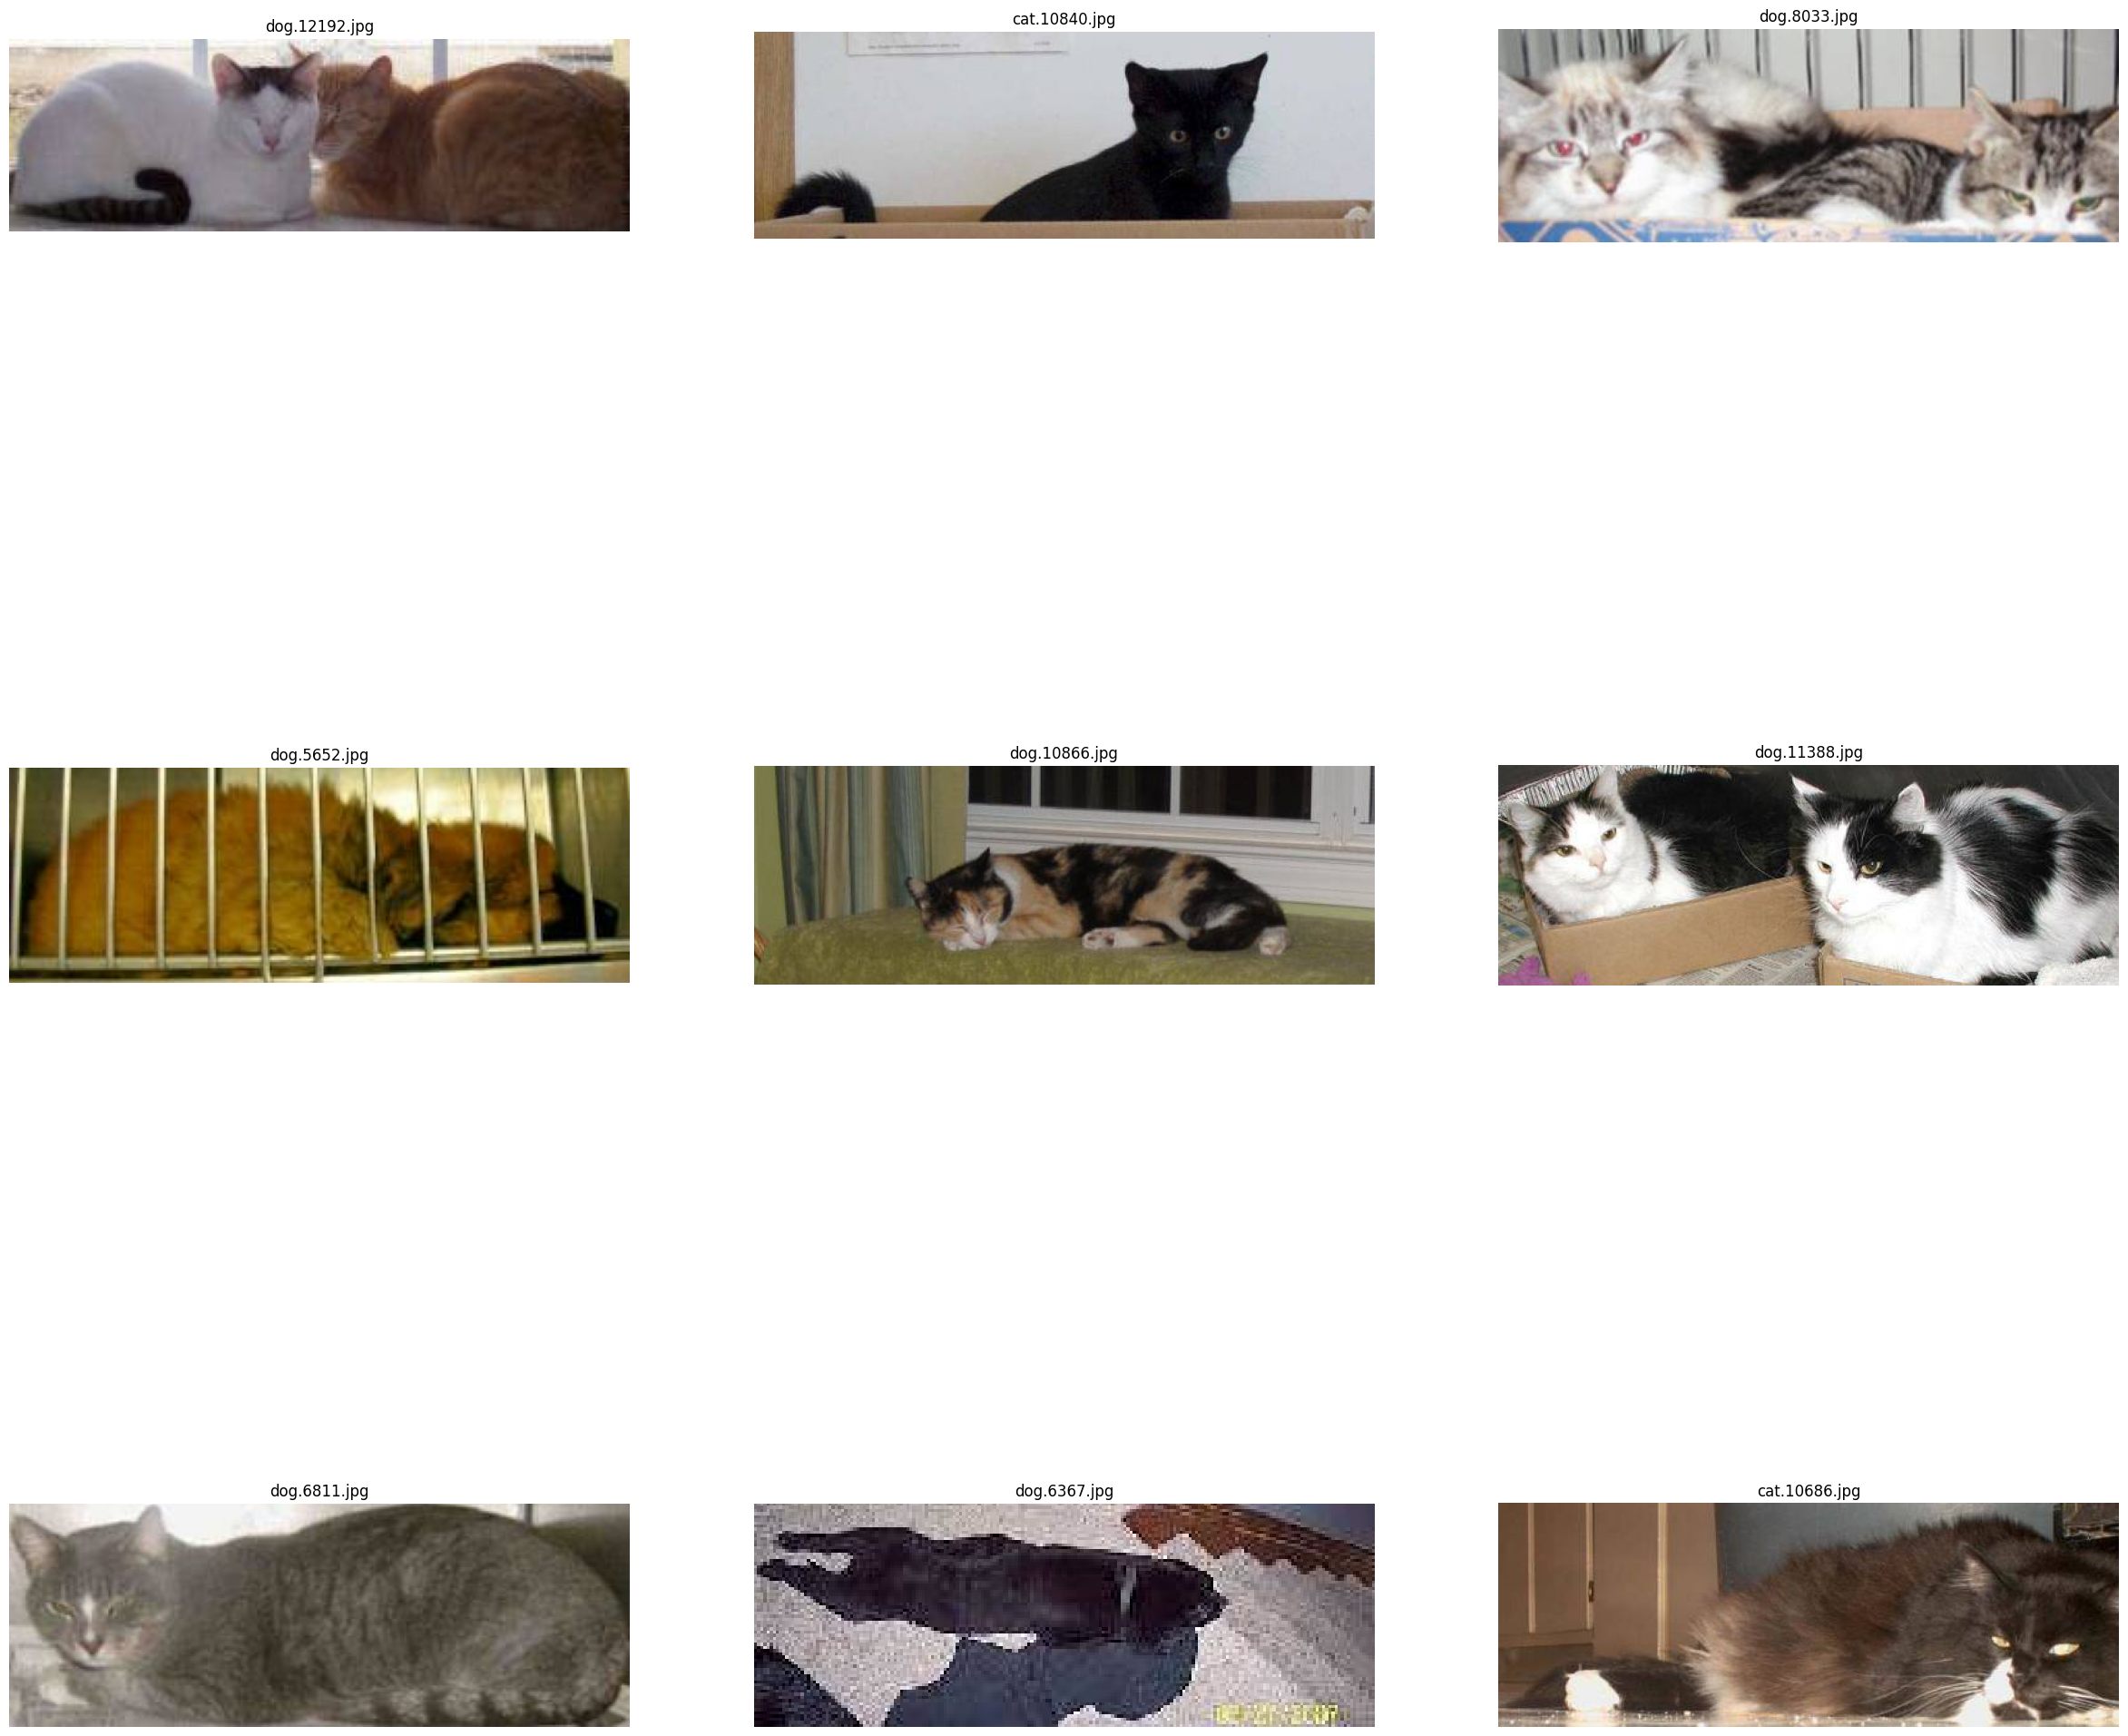

In [13]:
# Check Aagin
display_first_9(train_data_path,train_df)

<ipython-input-14-667024fbbcd7>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.countplot(data=train_df,x='Category',palette='viridis')


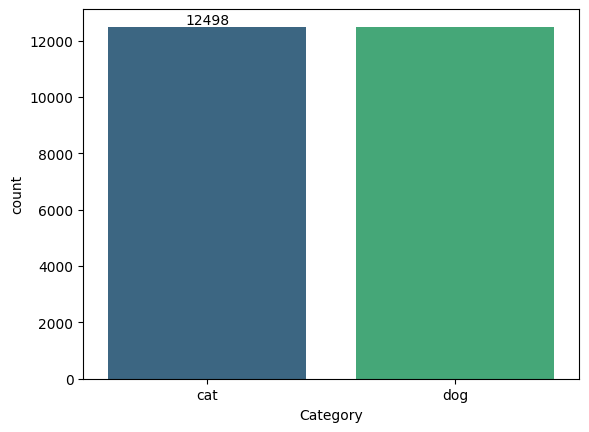

In [14]:
ax=sns.countplot(data=train_df,x='Category',palette='viridis')
ax.bar_label(ax.containers[0])
plt.show()

# Split the training data into training, test, and validation sets
This is done to evaluate the model and understand its performance.


In [15]:
# First split: 80% training and 20% temporary (validation + test)
train_df, temp_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['Category'])

# Second split: 50% of temp_df for validation and 50% for test (10% of original data each)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['Category'])

<ipython-input-16-d731f4f0dcec>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=train_df, x='Category', palette='viridis')
<ipython-input-16-d731f4f0dcec>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=test_df, x='Category', palette='viridis')
<ipython-input-16-d731f4f0dcec>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=val_df, x='Category', palette='viridis')


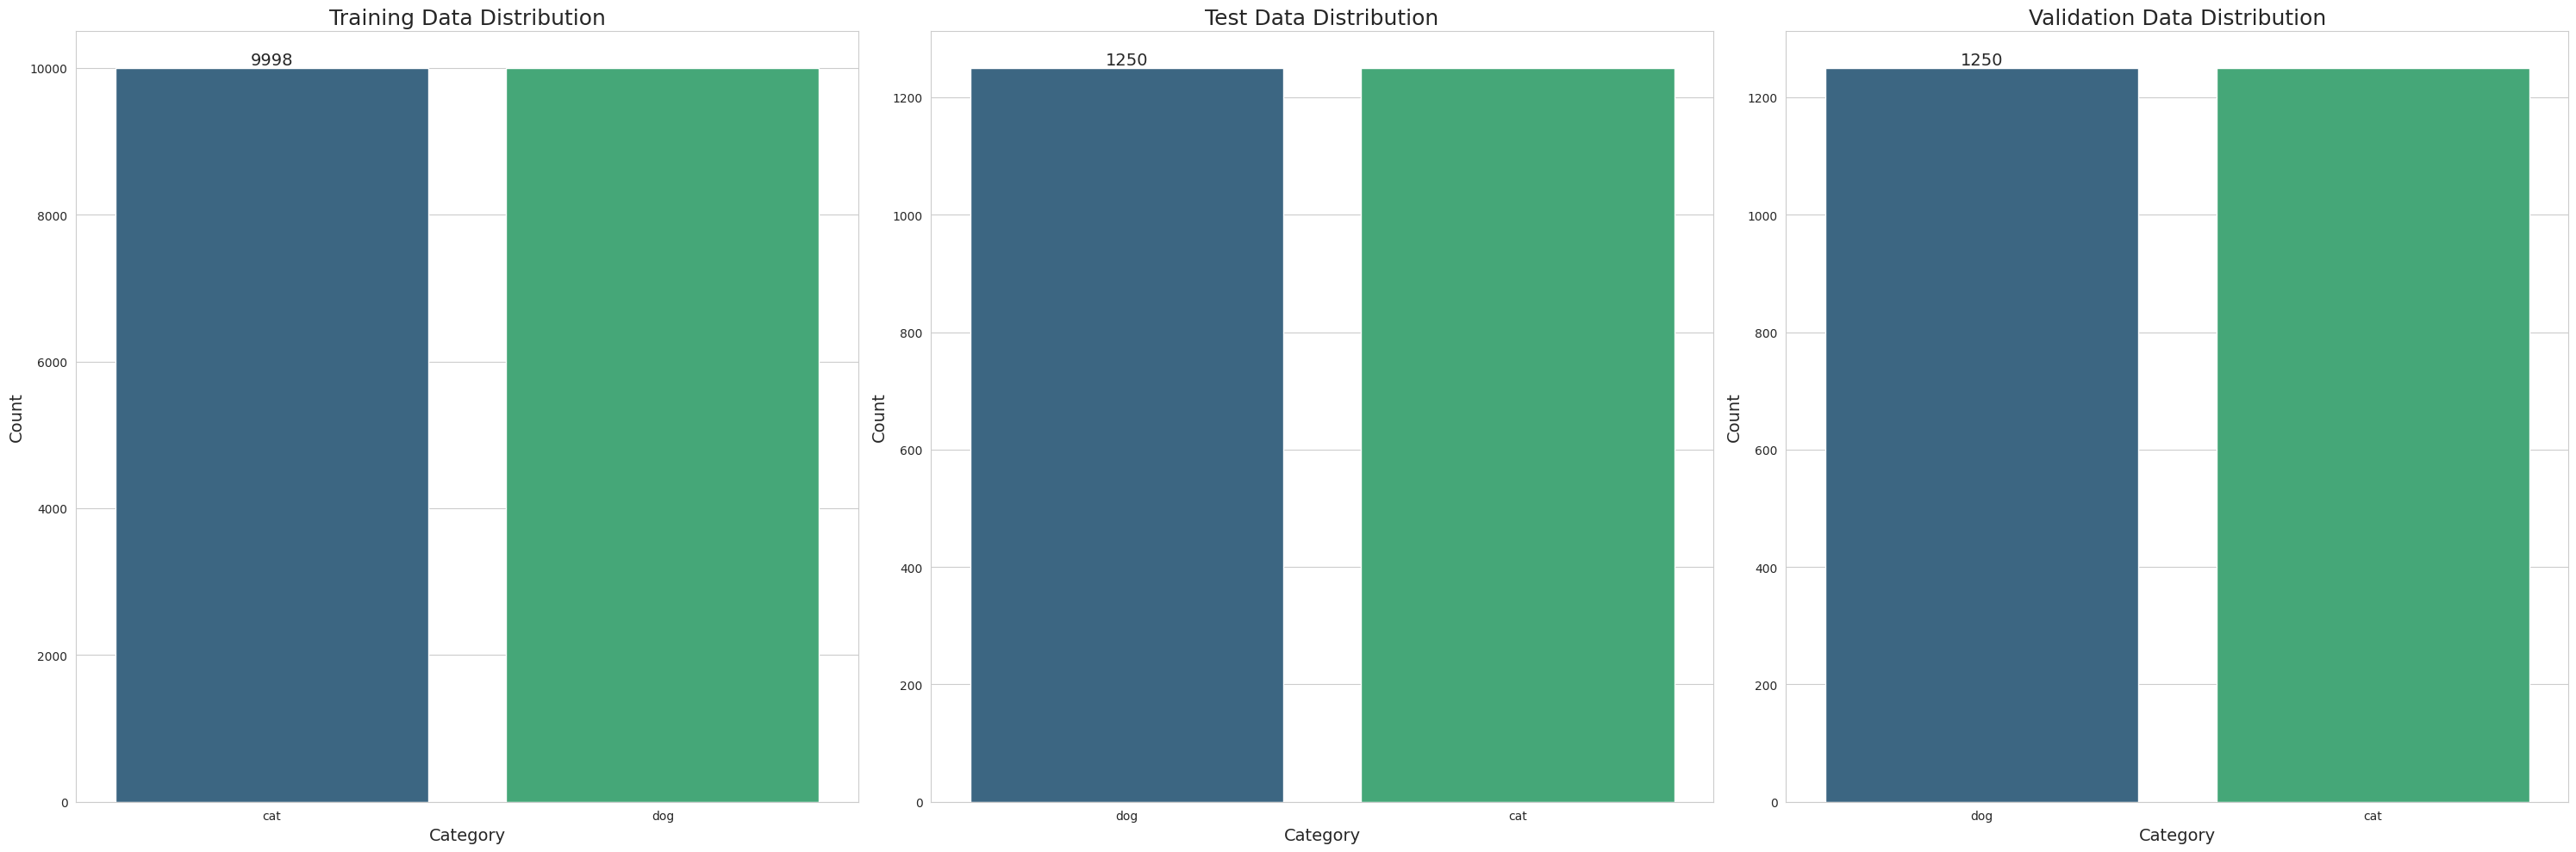

In [16]:
# Set the style of the figure
# Options: "whitegrid", "darkgrid", "white", "dark", "ticks"
sns.set_style("whitegrid")
plt.figure(figsize=(30, 10))

# Training Data Count Plot
plt.subplot(1, 3, 1)
ax = sns.countplot(data=train_df, x='Category', palette='viridis')
ax.bar_label(ax.containers[0], fontsize=14)
plt.title('Training Data Distribution', fontsize=18)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Test Data Count Plot
plt.subplot(1, 3, 2)
ax = sns.countplot(data=test_df, x='Category', palette='viridis')
ax.bar_label(ax.containers[0], fontsize=14)
plt.title('Test Data Distribution', fontsize=18)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Validation Data Count Plot
plt.subplot(1, 3, 3)
ax = sns.countplot(data=val_df, x='Category', palette='viridis')
ax.bar_label(ax.containers[0], fontsize=14)
plt.title('Validation Data Distribution', fontsize=18)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.tight_layout()
plt.show()

In [17]:
train_df.sort_values(by='Size',ascending=False)

Image_Name Category  Code         Size  Aspect_ratio
1126     cat.835.jpg      cat     0  (768, 1023)      0.750733
19686   dog.2317.jpg      dog     1  (702, 1050)      0.668571
9312    dog.9719.jpg      dog     1   (500, 499)      1.002004
13232   cat.6036.jpg      cat     0   (500, 499)      1.002004
21411   dog.4264.jpg      dog     1   (500, 499)      1.002004
...              ...      ...   ...          ...           ...
13384   dog.9705.jpg      dog     1     (39, 59)      0.661017
24687  dog.10747.jpg      dog     1     (38, 50)      0.760000
24634  dog.11248.jpg      dog     1     (37, 99)      0.373737
13564   cat.5534.jpg      cat     0     (36, 59)      0.610169
21513   cat.6402.jpg      cat     0     (32, 60)      0.533333

[19997 rows x 5 columns]

# Image Data Generator

In [18]:
image_size=(224,224)
image_channels=3
image_shape=(image_size[0],image_size[1],3)
batch_size = 32
epochs = 5

Data augmentation (like flipping, shifting, zooming, etc.) is typically applied only to the training set to introduce variability and prevent overfitting.

For validation and test sets, you generally avoid augmentations, as they are used to evaluate the model's performance on unmodified images.

In [19]:
train_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    horizontal_flip=True,
                                    zoom_range=0.2,
                                    width_shift_range=0.3,
                                    height_shift_range=0.3,
                                    rotation_range=0.3,
                                    shear_range=0.2,
                                    fill_mode='nearest')

train_generator = train_data_gen.flow_from_dataframe(
                                    dataframe=train_df,          # Your training DataFrame
                                    directory=train_data_path,   # Path to training data
                                    x_col='Image_Name',
                                    y_col='Category',
                                    batch_size=batch_size,
                                    shuffle=True,
                                    class_mode="binary",
                                    target_size=image_size)


Found 19997 validated image filenames belonging to 2 classes.


In [20]:
val_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_data_gen.flow_from_dataframe(
                                    dataframe=val_df,            # Your validation DataFrame
                                    directory=train_data_path,   # Path to validation data
                                    x_col='Image_Name',
                                    y_col='Category',
                                    batch_size=batch_size,
                                    shuffle=False,
                                    class_mode="binary",
                                    target_size=image_size)


test_generator = val_data_gen.flow_from_dataframe(
                                    dataframe=test_df,            # Your validation DataFrame
                                    directory=train_data_path,   # Path to validation data
                                    x_col='Image_Name',
                                    y_col='Category',
                                    batch_size=batch_size,
                                    shuffle=False,
                                    class_mode="binary",
                                    target_size=image_size)

Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


You can still apply the preprocessing_function=preprocess_input to your validation and test data because it ensures consistency with how the model was trained.

# Show Sample From Train Data after augmentation
Calling next(train_generator) retrieves the next batch of data from this generator. Each batch is a tuple containing two elements:

* images: A NumPy array of shape (batch_size, height, width, channels), representing the batch of images.
* labels: A NumPy array of shape (batch_size, ) or (batch_size, num_classes), representing the labels for these images. The exact shape depends on the class_mode parameter (e.g., 'binary', 'categorical').

In [21]:
sample_batch=next(train_generator)
images,labels=sample_batch

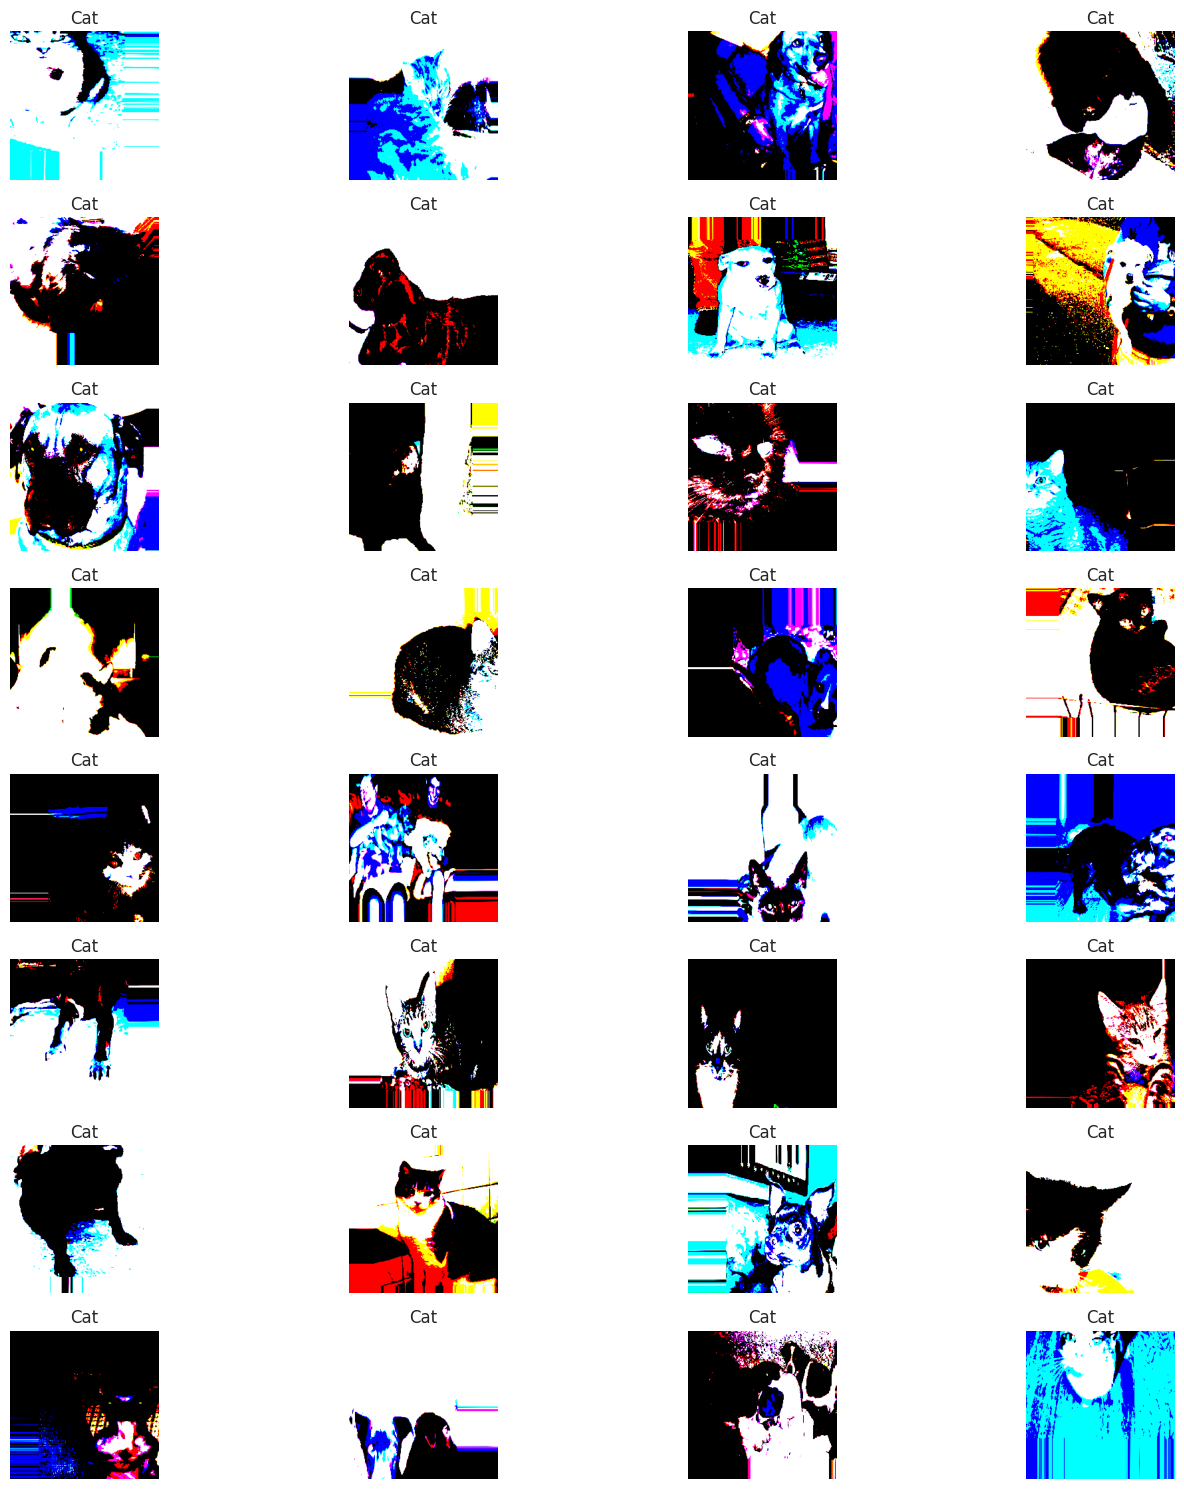

In [22]:
# this is what the resnet expect
plt.figure(figsize=(15,15))
for i in range(batch_size):
    plt.subplot(8,4,i+1)
    plt.imshow(images[i])
    label_index = np.argmax(labels[i])
    label='Cat' if label_index ==0 else 'Dog'
    plt.title(label)
    plt.axis('off')
plt.tight_layout()
plt.show()

# ReseNet

In [23]:
ResNet=ResNet50(weights='imagenet',include_top=False,input_shape=(image_size[0],image_size[1],3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [24]:
ResNet.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [25]:
# Get the output from the pre-trained ResNet model
resnet_output = ResNet.output

# Apply Global Average Pooling to reduce the dimensionality of the feature maps
gb = GlobalAveragePooling2D()(resnet_output)

# Add a Dropout layer to help prevent overfitting during training
drop = Dropout(0.5)(gb)

# Add a fully connected Dense layer with 1024 units and ReLU activation
# Apply L2 regularization to prevent overfitting
dense = Dense(1024, activation='relu', kernel_regularizer=l2(5e-4))(drop)

# Add another Dropout layer after the Dense layer
drop = Dropout(0.5)(dense)

# Create the output layer with 1 unit (binary classification: dog or cat) using sigmoid activation
predictions = Dense(1, activation='sigmoid')(drop)

# Define the model with the specified inputs (ResNet input) and outputs (predictions)
model = Model(inputs=ResNet.input, outputs=predictions)

# Display the model summary to show the architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 25,633,793 (97.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

## Model Callbacks¶
Set up some general callbacks for all instances of training. These are:

- checkpoints: save weights of model for best scores while training
- reduce learning rate: if training gains hit a plateau, try lowering learning rate
- early stopping: if no gain for several epochs in row, stop

Not all of these are really needed for this simple example, but I left them here since I find them useful to have around when generally training longer iterations.

In [26]:
checkpoint = ModelCheckpoint('../working/Resnet50_best.weights.h5', monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
                                   verbose=1, mode='auto', epsilon=0.0001)

early = EarlyStopping(monitor="val_loss", mode="min", patience=5)

callbacks_list = [checkpoint, reduceLROnPlat, early]

In [27]:
#the total number of images we have:
train_size = len(train_generator.filenames)
#train_steps is how many steps per epoch Keras runs the genrator. One step is batch_size*images
train_steps = train_size/batch_size
#use 2* number of images to get more augmentations in. some do, some dont. up to you
train_steps = int(2*train_steps)

#same for the validation set
valid_size = len(val_generator.filenames)
valid_steps = valid_size/batch_size
valid_steps = int(2*valid_steps)

#same for the test set
test_size = len(test_generator.filenames)
test_steps = test_size/batch_size
test_steps = int(2*test_steps)

In [28]:
# Step 1: Freeze the ResNet layers
for layer in ResNet.layers:
    layer.trainable = False

# Step 2: Compile the model with frozen layers
model.compile(optimizer=Adam(learning_rate=0.1), loss='binary_crossentropy', metrics=['accuracy'])

# Step 3: Train the model with frozen ResNet layers
history=model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=valid_steps,
    callbacks=callbacks_list,
    verbose=1
)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   6/1249 ━━━━━━━━━━━━━━━━━━━━ 2:16:22 7s/step - accuracy: 0.5130 - loss: 482.6017

KeyboardInterrupt: 

In [ ]:
# Step 4: Unfreeze the ResNet layers for fine-tuning
for layer in ResNet.layers:
    layer.trainable = True

# Step 5: Re-compile the model after unfreezing the layers (with potentially a lower learning rate)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Step 6: Train the model again with the unfrozen ResNet layers (fine-tuning)
new_history=model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=valid_steps,
    callbacks=callbacks_list,
    verbose=1
)

In [ ]:
history.history['loss'] += new_history.history['loss']
history.history['val_loss'] += new_history.history['val_loss']
history.history['accuracy'] += new_history.history['accuracy']
history.history['val_accuracy'] += new_history.history['val_accuracy']

In [ ]:
history.history.keys()

In [ ]:
loss=history.history['loss']
val_loss=history.history['val_loss']
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

# Find the epoch with the minimum validation loss (best performance in terms of loss)
index_loss = np.argmin(val_loss)
# Find the epoch with the maximum validation accuracy (best performance in terms of accuracy)
index_acc = np.argmax(val_acc)

# Get the lowest validation loss value at the best epoch
val_lowest = val_loss[index_loss]
# Get the highest validation accuracy value at the best epoch
val_highest = val_acc[index_acc]

# Create a list of epoch numbers, starting from 1, for plotting purposes
epochs=[i+1 for i in range(len(acc))]

# Create labels for plotting the best epoch in terms of loss and accuracy
loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

In [ ]:
# Set the style of the plot using 'fivethirtyeight' for a cleaner look
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,8))

# Create the first subplot (1 row, 2 columns, this is the first plot)
plt.subplot(1,2,1)
# Plot training loss across epochs
plt.plot(epochs, loss, 'r', label='Training Loss')
# Plot validation loss across epochs
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
# Highlight the point with the lowest validation loss with a blue dot
plt.scatter((index_loss+1), val_lowest, label=loss_label, s=150, c='b')
# Set the title, x-axis label, and y-axis label for the loss plot
plt.title('Training vs Validation (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Show the legend to differentiate between training and validation curves
plt.legend()

# Create the second subplot (2nd plot of the 1 row, 2 column layout)
plt.subplot(1,2,2)
# Plot training accuracy across epochs
plt.plot(epochs, acc, 'r', label='Training Accuracy')
# Plot validation accuracy across epochs
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
# Highlight the point with the highest validation accuracy with a blue dot
plt.scatter((index_acc+1), val_highest, label=acc_label, s=150, c='b')
# Set the title, x-axis label, and y-axis label for the accuracy plot
plt.title('Training vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Show the legend to differentiate between training and validation curves
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
history.history

In [ ]:
# Exclude learning_rate if it's of a different length
history_dict = {k: v for k, v in history.history.items() if len(v) == len(history.history['accuracy'])}

# Create DataFrame
df_history = pd.DataFrame(history_dict)
df_history

# Let's look at the models biggest mistakes
Maybe we can learn something from the ones where it makes the largest misclassifications.

Re-run predictions on the whole validation set to make sure that we are working with the latest model predictions
- This can be especially useful if you've made adjustments to the model or hyperparameters and want to validate the changes.

Collect probability of cat/dog
- this allows you to not only see the predicted label (which could be binary, i.e., cat or dog) but also the model's confidence in that prediction:

Resetting the generator
- The `valid_generator.reset()` is resetting the validation data generator, ensuring that the generator starts from the beginning of the validation set.

`np_img[np.newaxis]`: Adds a new axis to the image to make it compatible with the model’s expected input shape (batch size, height, width, channels).

In [ ]:
val_generator.reset()
df_valid = pd.DataFrame()

In [ ]:
# os.path.join(dir1,dir2)==(f'{dir1}/{dir2}')
# plt.imread('')==np.array(Image.open(''))

In [ ]:
# Initialize lists to store differences, predictions, categories, and labels
diffs = []
predictions = []
cat_or_dog = []
labels = []

# Iterate through each filename in the validation generator
for file in val_generator.filenames:
    # Create the full image path
    img_path = os.path.join(train_data_path, file)
    img = Image.open(img_path)
    # Resize the image to the specified dimensions
    img = img.resize((image_size[0], image_size[1]))
    # Convert the image to a NumPy array
    img = np.array(img)

    # Determine the reference label based on the filename
    if 'cat' == file.split('.')[0]:
        ref = 0
        cat_or_dog.append('cat')
    else:
        ref = 1
        cat_or_dog.append('dog')

    labels.append(ref)
    pred = model.predict(preprocess_input(img[np.newaxis]))
    predictions.append(pred)
    diffs.append(np.abs(pred[0][0] - ref))

In [ ]:
df_valid["filename"] = val_generator.filenames
df_valid["cat_or_dog"] = cat_or_dog
df_valid["label"] = labels
df_valid["diff"] = diffs
df_valid["prediction"] = predictions

In [ ]:
sorted_diffs=df_valid.sort_values(by='diff',ascending=False)

 ## Plot the top N misclassifications

In [ ]:
def plot_top_N(N, sorted_df):
    from math import ceil
    # Initialize index for subplot tracking
    i = 0
    rows = int(ceil(N / 3))  # Calculate number of rows needed
    height = rows * 10  # Determine plot height based on rows
    plt.figure(figsize=[30, height])  # Set figure size (width fixed, height scales)

    # Iterate over each row in the sorted DataFrame
    for index, row in sorted_df.iterrows():
        # Create subplot for the current image
        plt.subplot(rows, 3, i + 1)

        # Extract data from the DataFrame row
        file_name = row["filename"]
        category = row["cat_or_dog"]  # True label as string ('cat' or 'dog')
        true_label = row["label"]  # True label as 0 or 1
        diffs = row["diff"]  # Difference between prediction and actual
        predictions = row["prediction"]  # Predicted probability

        # Determine predicted label based on model prediction
        pred_label = 1 if predictions[0][0] > 0.5 else 0  # 1 = dog, 0 = cat
        predicted_category = 'dog' if pred_label == 1 else 'cat'  # Predicted category as string

        # Open and display image
        img = Image.open(f"{train_data_path}/{file_name}")
        plt.imshow(img)

        # Set title with model prediction and difference
        plt.title(f'It is a {category}, model predicted as {predicted_category} with {predictions[0][0]:.2f}, error {diffs:.2f}')

        i += 1
        img.close()  # Close image to free memory

        if i >= N:  # Stop when the top N images are plotted
            break

In [ ]:
plot_top_N(10,sorted_diffs)

# Evalute the model

In [ ]:
nb_samples=len(test_generator.filenames)
nb_samples

In [ ]:
predict=model.predict(test_generator,steps=int(np.ceil(nb_samples/batch_size)))
test_df['Predication']=(predict > .5).astype(int)

In [ ]:
test_df

In [ ]:
print(val_generator.class_indices)
print(val_generator.class_indices.items())

In [ ]:
labels=dict((v,k) for k,v in val_generator.class_indices.items())
labels

# Model misclassification

In [ ]:
test_df[test_df['Code']!=test_df['Predication']]

In [ ]:
train_loss, train_accuracy = model.evaluate(train_generator, steps=int(np.ceil(len(train_generator.filenames) / batch_size)))
test_loss, test_accuracy = model.evaluate(test_generator, steps=int(np.ceil(len(test_generator.filenames) / batch_size)))
val_loss, val_accuracy = model.evaluate(val_generator, steps=int(np.ceil(len(val_generator.filenames) / batch_size)))

# Predictions

In [ ]:
image_name=[]
size=[]
aspect_ratio=[]

for image in test_images:
    image_name.append(image)
    img_path=os.path.join(test_data_path,image)

    # Read the image to get its size (height, width)
    img=cv2.imread(img_path)
    size.append((img.shape[0],img.shape[1]))
    # Calculate and append the aspect ratio (height/width) of the image
    aspect_ratio.append(img.shape[0]/img.shape[1])

test_df=pd.DataFrame({'Image_Name':image_name})
test_df

In [ ]:
test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_data_gen.flow_from_dataframe(
                                    dataframe=test_df,          # Your test DataFrame
                                    directory=test_data_path,   # Path to test data
                                    x_col='Image_Name',
                                    y_col=None,
                                    batch_size=batch_size,
                                    shuffle=False,
                                    class_mode=None,            # Set to None since there are no labels
                                    target_size=image_size)

In [ ]:
pred=model.predict(test_generator,steps=int(np.ceil(len(test_generator.filenames))))

In [ ]:
test_df['Predication']=(pred>.5).astype(int)

In [ ]:
test_df['Category']=test_df['Predication'].map({0:'cat',1:'dog'})
test_df

# See predicted result


In [ ]:
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    plt.subplot(3, 3, index+1)
    filename = row['Image_Name']
    category = row['Category']
    img = Image.open(f'{test_data_path}/{filename}')
    plt.imshow(img)
    plt.title(f'Image {filename} Predicated as {category}',fontsize=12)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Submission

In [ ]:
test_df

In [ ]:
# Creating the submission DataFrame
submission_df = test_df.copy()
submission_df['id'] = submission_df['Image_Name'].str.split('.').str[0]
submission_df['label'] = submission_df['Predication']
submission_df.drop(['Image_Name', 'Category', 'Predication'], axis=1, inplace=True)

# Saving the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

# Plotting the count of labels
plt.figure(figsize=(10,5))
sns.countplot(x='label', data=submission_df)
plt.title("Label distribution in Test data")
plt.show()
